In [155]:
!pip install graphviz 

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import roc_auc_score
from tune_sklearn import TuneSearchCV

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import classification_report, accuracy_score
from tune_sklearn import TuneSearchCV

import statsmodels
from statsmodels.stats.outliers_influence import variance_inflation_factor
from matplotlib import pyplot as plt

import yfinance as yf
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")

## 1. Read Data

In [2]:
data = pd.read_excel('DataSet.xlsx')

In [3]:
data = data.set_index('ID')

In [4]:
data.columns

Index(['Company', 'Sector', 'Date', 'Key', 'Type', 'Positive', 'Negative',
       'Total Words', 'Positive Extended', 'Negative Extended',
       'New Total Words', 'Number of sentences in MD',
       'Avg length of sentences in MD', 'Polarity LM', 'Polarity LM extended',
       'negative', 'neutral', 'positive', '1-Day Returns', '1-Day S&P Returns',
       '1-Day adj', '3-Day Returns', '3-Day S&P Returns', '3-Day adj',
       '5-Day Returns', '5-Day S&P Returns', '5-Day adj', '30-Day Returns',
       '30-Day S&P Returns', '30-Day adj', '60-Day Returns',
       '60-Day S&P Returns', '60-Day adj', '90-Day Returns',
       '90-Day S&P Returns', '90-Day adj'],
      dtype='object')

In [5]:
features=data.columns[5:18]
features

Index(['Positive', 'Negative', 'Total Words', 'Positive Extended',
       'Negative Extended', 'New Total Words', 'Number of sentences in MD',
       'Avg length of sentences in MD', 'Polarity LM', 'Polarity LM extended',
       'negative', 'neutral', 'positive'],
      dtype='object')

## 2. Match company name with cik

In [6]:
# Try to get the company name using cik
ticker_library = pd.read_csv('SHARADAR_TICKERS_6cc728d11002ab9cb99aa8654a6b9f4e.csv')
ticker_selected = pd.read_csv('SP500_component_stocks.csv',header = None)
ticker_selected.columns = ['name','ticker']

In [7]:
def ticker_cik(file):
    return str(file)[-10:]

In [8]:
ticker_library['cik'] = ticker_library['secfilings'].apply(ticker_cik)
ticker_cik_df = ticker_library[['ticker', 'cik']]
ticker_cik_df.head()

,ticker,cik
0,A,0001090872
1,AA,0001675149
2,AAAB,0001066808
3,AAAGY,0001182802
4,AAAP,0001611787


In [9]:
data['Company name'] = data['Company'].apply(lambda x: ticker_cik_df[ticker_cik_df['cik'] == (10 - len(str(x))) * '0' + str(x)]['ticker'].unique()[0])

## 2. We will divide into train (2013-2017) and test (2018-2019)

In [10]:
division_date = startdate=pd.Timestamp('2018-01-01')

In [11]:
msk=np.array(data['Date']<division_date)

In [12]:
train = data[msk]
test = data[~msk]

In [13]:
train_features = train[features].astype(np.float)
test_features = test[features].astype(np.float)

## 3. Get daily price data

In [14]:
start_test = min(test['Date'])
end_test = max(test['Date'])
tickers = list(set(test["Company name"]))

In [15]:
end_test

Timestamp('2019-08-13 00:00:00')

In [16]:
sp_data = yf.download(tickers, start = start_test, end = end_test + timedelta(days = 1))['Adj Close']
sp_return = sp_data.pct_change().shift(-1)
trading_date = list(sp_return.index)[:-1]
sp_return = sp_return.reset_index()
sp_return['Date'] = pd.to_datetime(sp_return['Date'])
sp_return = sp_return.iloc[:-1, :].reset_index(drop = True)

[*********************100%***********************]  46 of 46 completed

1 Failed download:
- VIAC: Data doesn't exist for startDate = 1517202000, endDate = 1565755200


In [17]:
viac = pd.read_csv('VIAC Historical Data.csv')

In [18]:
viac['VIAC'] = viac['Price'].pct_change().shift(-1)

In [19]:
viac['Date'] = pd.to_datetime(viac['Date'])

In [20]:
sp_return = pd.merge(sp_return.drop(columns = 'VIAC'), viac[['Date', 'VIAC']], on = 'Date', how = 'left')

## 4. Create an empty dataframe to record daily performance

In [21]:
def InitializeEmptyDataframe(start_date, end_date, tickers):
    
    window_length_days = int((end_date - start_date).days)
    date_list = [start_date+timedelta(days=x) for x in range(0, window_length_days)]
    long_date_list = date_list * len(tickers)
    long_date_list = [x.strftime('%Y-%m-%d') for x in long_date_list]
    list.sort(long_date_list)
    empty = pd.DataFrame(data={'Date': long_date_list, 
                               'Company name': tickers*len(date_list),
                              })
    
    empty['Date'] = pd.to_datetime(empty['Date'])
    empty = empty.groupby(['Date', 'Company name']).sum()
    
    return empty

In [22]:
empty_data = InitializeEmptyDataframe(start_test, end_test, tickers)

## 5. Create binary response variable

In [23]:
np.mean(train['30-Day adj'])

1.430213023001399

In [24]:
np.median(train['30-Day adj'])

0.3473030678595279

In [25]:
np.median(test['30-Day adj'])

nan

In [26]:
np.mean(test['30-Day adj'])

0.7544315806100279

In [27]:
y_train1 = np.array(train['3-Day adj'].apply(lambda x:1 if x >1.0 else -1))# if x < -1.0 else 0))
y_train2 = np.array(train['5-Day adj'].apply(lambda x:1 if x >1.0 else -1))# if x < -1.0 else 0))
y_train3 = np.array(train['30-Day adj'].apply(lambda x:1 if x >1.0 else -1))# if x < -1.0 else 0))
y_train4 = np.array(train['60-Day adj'].apply(lambda x:1 if x >1.0 else -1))# if x < -1.0 else 0))

In [28]:
y_test1 = np.array(test['3-Day adj'].apply(lambda x:1 if x >1.0 else -1))# if x < -1.0 else 0))
y_test2 = np.array(test['5-Day adj'].apply(lambda x:1 if x >1.0 else -1))# if x < -1.0 else 0))
y_test3 = np.array(test['30-Day adj'].apply(lambda x:1 if x >1.0 else -1))# if x < -1.0 else 0))
y_test4 = np.array(test['60-Day adj'].apply(lambda x:1 if x >1.0 else -1))# if x < -1.0 else 0))

Check if the response variable is balanced

(array([461.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 391.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

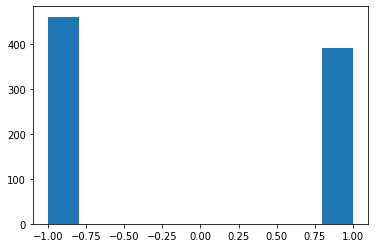

In [29]:
plt.hist(y_train3)

(array([128.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 113.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

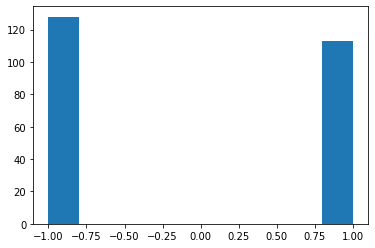

In [30]:
plt.hist(y_test3)

## 6. Check for multi-colinearity

First we will look for multicollinearity using the Variance Inflation Factor (VIF)

In [31]:
def vif(data):
    vif_data = pd.DataFrame() 
    vif_data["feature"] = data.columns
    vif_data["VIF"] = [variance_inflation_factor(data.values.astype(float), i) for i in range(len(data.columns))] 
    return vif_data

In [32]:
vif(train_features)

,feature,VIF
0,Positive,inf
1,Negative,inf
2,Total Words,inf
3,Positive Extended,inf
4,Negative Extended,inf
5,New Total Words,inf
6,Number of sentences in MD,143.928164
7,Avg length of sentences in MD,4.063543
8,Polarity LM,3.588406
9,Polarity LM extended,2.293326


## 7. Do some feature engineering to fix multi-colinearity

We see that there is perfect correlation between Positive, Negative, Total Words, Positive Extended, Negative Extended and New Total words. Since polarity includes the information present on them we can remove them. We also observe high correlation among the number of sentences and the finbert neutral sentences (we create features of polarity as well for finBERT)

In [33]:
train_features['Polarity of sentences'] = (train_features['positive'] - train_features['negative'])/train_features['Number of sentences in MD']
test_features['Polarity of sentences'] = (test_features['positive'] - test_features['negative'])/test_features['Number of sentences in MD']

In [34]:
train_features['Percentage neutral sentences'] = train_features['neutral']/train_features['Number of sentences in MD']
test_features['Percentage neutral sentences'] = test_features['neutral']/test_features['Number of sentences in MD']

In [35]:
selected_features = ['Polarity LM','Polarity LM extended','Polarity of sentences','Avg length of sentences in MD','Percentage neutral sentences']

In [36]:
train_features2 = train_features[selected_features]
test_features2 = test_features[selected_features]

In [37]:
test_features

,Positive,Negative,Total Words,Positive Extended,Negative Extended,New Total Words,Number of sentences in MD,Avg length of sentences in MD,Polarity LM,Polarity LM extended,negative,neutral,positive,Polarity of sentences,Percentage neutral sentences
ID,,,,,,,,,,,,,,,
5,126.0,153.0,12558.0,1343.0,896.0,14518.0,887.0,18.0,-0.002150,0.030789,6.0,400.0,92.0,0.096956,0.450958
6,123.0,125.0,11592.0,1352.0,646.0,13342.0,798.0,18.0,-0.000173,0.052916,8.0,365.0,105.0,0.121554,0.457393
18,46.0,36.0,3622.0,46.0,36.0,3622.0,253.0,18.0,0.002761,0.002761,0.0,97.0,35.0,0.138340,0.383399
19,44.0,37.0,3905.0,184.0,37.0,4045.0,281.0,17.0,0.001793,0.036341,0.0,100.0,32.0,0.113879,0.355872
20,45.0,41.0,4292.0,185.0,41.0,4432.0,309.0,17.0,0.000932,0.032491,1.0,110.0,32.0,0.100324,0.355987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1088,33.0,27.0,4783.0,163.0,81.0,4967.0,251.0,24.0,0.001254,0.016509,3.0,143.0,16.0,0.051793,0.569721
1089,33.0,28.0,5005.0,193.0,72.0,5209.0,253.0,26.0,0.000999,0.023229,3.0,145.0,14.0,0.043478,0.573123
1090,260.0,453.0,28544.0,2619.0,2515.0,32965.0,1118.0,32.0,-0.006761,0.003155,5.0,683.0,185.0,0.161002,0.610912


In [44]:
vif(train_features2)

,feature,VIF
0,Polarity LM,3.004692
1,Polarity LM extended,1.603702
2,Polarity of sentences,1.144860
3,Avg length of sentences in MD,9.065910
4,Percentage neutral sentences,8.332712


Using only FinBERT features

In [45]:
selected_features3 = ['Polarity of sentences','Avg length of sentences in MD','Percentage neutral sentences']

In [46]:
train_features3 = train_features[selected_features3]
test_features3 = test_features[selected_features3]

## 8. Run different models

In [47]:
def create_X(train_features,test_features):
    X_train = train_features.values
    X_test = test_features.values
    return X_train,X_test

In [48]:
X_train,X_test = create_X(train_features[features],test_features[features])

In [49]:
X_train2,X_test2 = create_X(train_features2,test_features2)

In [50]:
X_train3,X_test3 = create_X(train_features3,test_features3)

In [51]:
def match_price(row):
    temp_company = row['Company name']
    temp_date = row['Date']
    return sp_return[sp_return['Date'] == temp_date][temp_company].values[0]

In [52]:
def metrics(portfolio, title, benchmark):
    average_annualized_return = np.mean(portfolio) * 250
    benchmark_return = np.mean(benchmark) * 250
    annualized_std = (np.std(portfolio) - np.std(benchmark)) * np.sqrt(250)
    IR = (average_annualized_return - benchmark_return) / annualized_std
    max_drawdown = np.min(pd.Series(np.cumprod([ _ + 1 for _ in portfolio]))
                          - pd.Series(np.cumprod([ _ + 1 for _ in portfolio])).cummax())
    print('-' * 50)
    print(title + ' portfolio performance：')
    print("Average Annualized Return is: ", average_annualized_return)
    print("Information Ratio is: ", IR)
    print("Maximum Drawdown is: ", max_drawdown)

In [55]:
def portfolio(pred, test, n):
    test['Pred'] = pred
    formatted_test = empty_data.join(test.set_index(["Date", "Company name"]),
                                 how='left', 
                                 on=['Date', 'Company name'], 
                                 lsuffix='_empty')
    formatted_test = formatted_test.sort_values(by=['Company name', 'Date']).reset_index()

    forward_filled_test = pd.DataFrame(columns = list(formatted_test.columns))
    for company in list(formatted_test['Company name'].unique()):
        temp = formatted_test[formatted_test['Company name'] == company].copy()
        temp.fillna(method='ffill', inplace=True, limit=n-1)
        forward_filled_test = pd.concat([forward_filled_test, temp])
    
    trading_date_df = pd.DataFrame(trading_date, columns = ['Date'])
    test_trading = pd.merge(forward_filled_test, trading_date_df, how = 'inner', on = 'Date')
    test_trading['Daily return'] = test_trading.apply(match_price, axis = 1)

    # Construct portfolio
    dates = list(test_trading['Date'].unique())
    portfolio_result = pd.DataFrame(test_trading['Date'].unique(), columns = ['Date'])

    return_base = []
    return_long = []
    return_longshort = []

    for date in dates:
        temp = test_trading[test_trading['Date'] == date]
        temp_all = temp['Daily return']
        temp_long = temp[temp['Pred'] == 1]['Daily return']
        temp_short = temp[temp['Pred'] == -1]['Daily return']
        temp_longshort = pd.concat([temp_long, temp_short * (-1)])
        return_base.append(np.mean(temp_all))
        return_long.append(np.mean(temp_long))
        return_longshort.append(np.mean(temp_longshort))
    
    portfolio_result['Date'] = portfolio_result['Date'].apply(lambda x: str(x).split()[0])
    portfolio_result['Benchmark'] = return_base
    portfolio_result['Long strategy'] = return_long
    portfolio_result['Long-short strategy'] = return_longshort
    portfolio_result = portfolio_result.fillna(0)

    plt.figure(figsize = [10, 6])
    plt.plot([1] + list(np.cumprod(portfolio_result['Benchmark'].apply(lambda x: x + 1))), label = 'Benchmark')
    #plt.plot([1] + list(np.cumprod(portfolio_result['Long strategy'].apply(lambda x: x + 1))), label = 'Long strategy')
    plt.plot([1] + list(np.cumprod(portfolio_result['Long-short strategy'].apply(lambda x: x + 1))), label = 'Long-short strategy')
    plt.xticks(range(0, len(portfolio_result), 100), portfolio_result.iloc[np.arange(0, len(portfolio_result), 100)]['Date'])
    plt.legend()
    plt.show()

    metrics(portfolio_result['Long strategy'], 'Long', np.cumprod(portfolio_result['Benchmark']))
    metrics(portfolio_result['Long-short strategy'], 'Long-short', np.cumprod(portfolio_result['Benchmark']))

## 8.1 Logistic Regression

In [56]:
def modeling_result(X_train, X_test, model, train_list, test_list, time_length):
    for i in range(len(train_list)):
        y_train_temp = train_list[i]
        y_test_temp = test_list[i]
        l = time_length[i]
        model.fit(X_train,y_train_temp)
        model_pred = model.predict(X_test)
        print('=' * 60)
        print(str(l) + '-Day Prediction:')
        print(classification_report(y_test_temp, model_pred))
        print(confusion_matrix(y_test_temp, model_pred))
        print(accuracy_score(y_test_temp,model_pred))
        portfolio(model_pred, test, l)

In [57]:
train_list = [y_train1, y_train2, y_train3, y_train4]
test_list = [y_test1, y_test2, y_test3, y_test4]

3-Day Prediction:
              precision    recall  f1-score   support

          -1       0.61      1.00      0.75       146
           1       0.00      0.00      0.00        95

    accuracy                           0.61       241
   macro avg       0.30      0.50      0.38       241
weighted avg       0.37      0.61      0.46       241

[[146   0]
 [ 95   0]]
0.6058091286307054


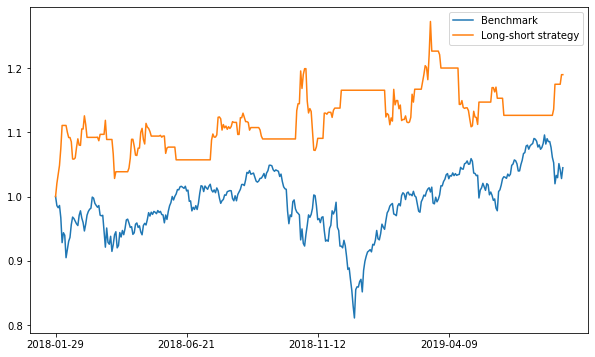

--------------------------------------------------
Long portfolio performance：
Average Annualized Return is:  0.0
Information Ratio is:  -0.802023125202408
Maximum Drawdown is:  0.0
--------------------------------------------------
Long-short portfolio performance：
Average Annualized Return is:  0.12637794560674087
Information Ratio is:  0.8612722448844021
Maximum Drawdown is:  -0.16392573440583713
5-Day Prediction:
              precision    recall  f1-score   support

          -1       0.62      1.00      0.76       149
           1       0.00      0.00      0.00        92

    accuracy                           0.62       241
   macro avg       0.31      0.50      0.38       241
weighted avg       0.38      0.62      0.47       241

[[149   0]
 [ 92   0]]
0.6182572614107884


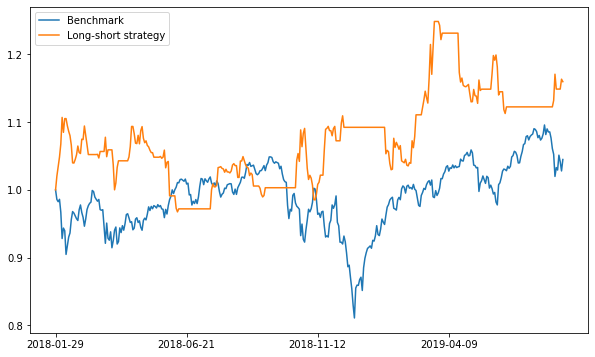

--------------------------------------------------
Long portfolio performance：
Average Annualized Return is:  0.0
Information Ratio is:  -0.802023125202408
Maximum Drawdown is:  0.0
--------------------------------------------------
Long-short portfolio performance：
Average Annualized Return is:  0.11271141109756751
Information Ratio is:  0.7030837220575539
Maximum Drawdown is:  -0.1393852188301563
21-Day Prediction:
              precision    recall  f1-score   support

          -1       0.52      0.93      0.67       128
           1       0.25      0.03      0.05       113

    accuracy                           0.51       241
   macro avg       0.38      0.48      0.36       241
weighted avg       0.39      0.51      0.38       241

[[119   9]
 [110   3]]
0.5062240663900415


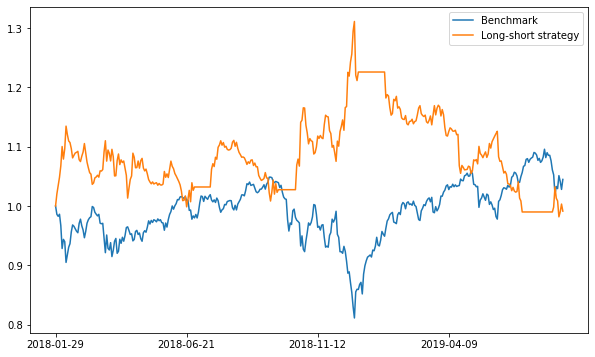

--------------------------------------------------
Long portfolio performance：
Average Annualized Return is:  0.08266319067828537
Information Ratio is:  0.5987549258144955
Maximum Drawdown is:  -0.23726473591792407
--------------------------------------------------
Long-short portfolio performance：
Average Annualized Return is:  0.014712619411408662
Information Ratio is:  0.1248265390889249
Maximum Drawdown is:  -0.32966723391736075
42-Day Prediction:
              precision    recall  f1-score   support

          -1       0.54      0.60      0.57       124
           1       0.52      0.46      0.49       117

    accuracy                           0.53       241
   macro avg       0.53      0.53      0.53       241
weighted avg       0.53      0.53      0.53       241

[[74 50]
 [63 54]]
0.5311203319502075


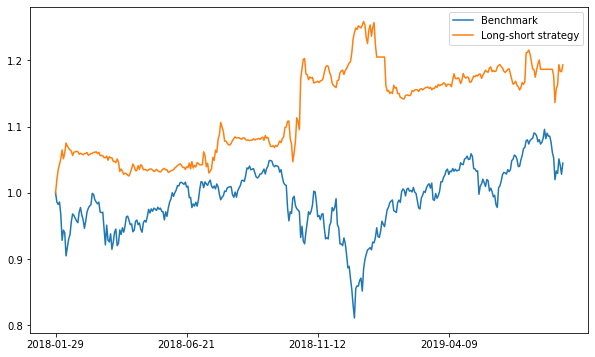

--------------------------------------------------
Long portfolio performance：
Average Annualized Return is:  0.24921733204034788
Information Ratio is:  1.4131696912761273
Maximum Drawdown is:  -0.23917725119634947
--------------------------------------------------
Long-short portfolio performance：
Average Annualized Return is:  0.12185901463276418
Information Ratio is:  1.148815383055426
Maximum Drawdown is:  -0.12247588972590662


In [58]:
#Logistic Regression
lc = LogisticRegression(solver='lbfgs', max_iter= 5000)
modeling_result(X_train2, X_test2, lc, train_list, test_list, [3, 5, 21, 42])

## 6.2 Random Forest

3-Day Prediction:
              precision    recall  f1-score   support

          -1       0.61      1.00      0.75       146
           1       0.00      0.00      0.00        95

    accuracy                           0.61       241
   macro avg       0.30      0.50      0.38       241
weighted avg       0.37      0.61      0.46       241

[[146   0]
 [ 95   0]]
0.6058091286307054


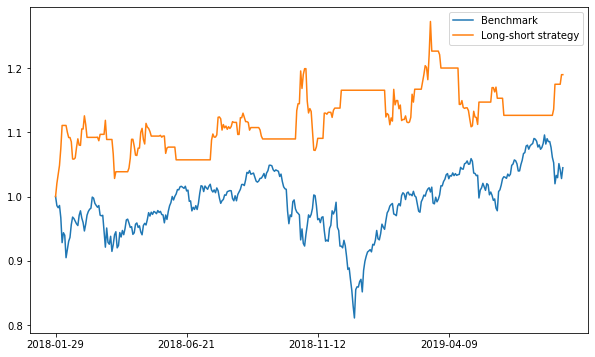

--------------------------------------------------
Long portfolio performance：
Average Annualized Return is:  0.0
Information Ratio is:  -0.802023125202408
Maximum Drawdown is:  0.0
--------------------------------------------------
Long-short portfolio performance：
Average Annualized Return is:  0.12637794560674087
Information Ratio is:  0.8612722448844021
Maximum Drawdown is:  -0.16392573440583713
5-Day Prediction:
              precision    recall  f1-score   support

          -1       0.62      1.00      0.76       149
           1       0.00      0.00      0.00        92

    accuracy                           0.62       241
   macro avg       0.31      0.50      0.38       241
weighted avg       0.38      0.62      0.47       241

[[149   0]
 [ 92   0]]
0.6182572614107884


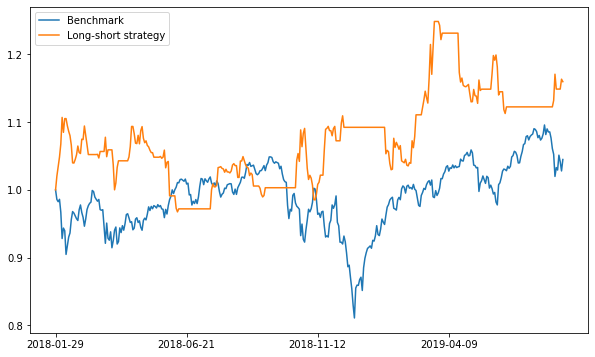

--------------------------------------------------
Long portfolio performance：
Average Annualized Return is:  0.0
Information Ratio is:  -0.802023125202408
Maximum Drawdown is:  0.0
--------------------------------------------------
Long-short portfolio performance：
Average Annualized Return is:  0.11271141109756751
Information Ratio is:  0.7030837220575539
Maximum Drawdown is:  -0.1393852188301563
21-Day Prediction:
              precision    recall  f1-score   support

          -1       0.53      0.88      0.66       128
           1       0.45      0.12      0.18       113

    accuracy                           0.52       241
   macro avg       0.49      0.50      0.42       241
weighted avg       0.49      0.52      0.44       241

[[112  16]
 [100  13]]
0.5186721991701245


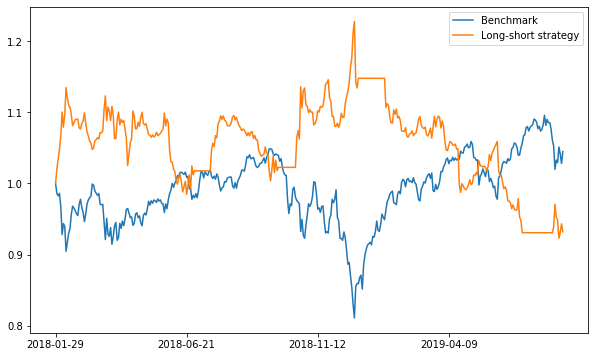

--------------------------------------------------
Long portfolio performance：
Average Annualized Return is:  0.17539270972660412
Information Ratio is:  1.2170939987954519
Maximum Drawdown is:  -0.26712381787630823
--------------------------------------------------
Long-short portfolio performance：
Average Annualized Return is:  -0.02685189395201051
Information Ratio is:  -0.09802528385367086
Maximum Drawdown is:  -0.304481168404782
42-Day Prediction:
              precision    recall  f1-score   support

          -1       0.53      0.68      0.59       124
           1       0.51      0.35      0.41       117

    accuracy                           0.52       241
   macro avg       0.52      0.51      0.50       241
weighted avg       0.52      0.52      0.51       241

[[84 40]
 [76 41]]
0.5186721991701245


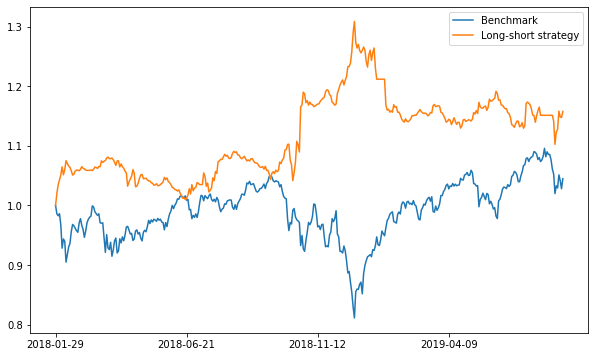

--------------------------------------------------
Long portfolio performance：
Average Annualized Return is:  0.30313344819861926
Information Ratio is:  1.6173170753355883
Maximum Drawdown is:  -0.20163150404040153
--------------------------------------------------
Long-short portfolio performance：
Average Annualized Return is:  0.1035468618953982
Information Ratio is:  0.9179424633494202
Maximum Drawdown is:  -0.20627792626778185


In [59]:
#Random Forest
rf =RandomForestClassifier(max_depth=2, random_state=0) 
modeling_result(X_train2, X_test2, rf, train_list, test_list, [3, 5, 21, 42])

## 6.3 XGBoost

### 6.3.1 Taking all features into consideration

In [52]:
clf = XGBClassifier(n_estimators = 100, n_jobs=4)#,objective='multi:softprob')
fit = clf.fit(X_train,y_train)
preds = clf.predict(X_test)
predproba = clf.predict_proba(X_test)
auc_score = roc_auc_score(y_test, preds, multi_class='ovr')

NameError: name 'y_train' is not defined

In [53]:
auc_score

NameError: name 'auc_score' is not defined

In [81]:
params = {
    "min_child_weight": [1, 5, 10],
    "gamma": [0.5, 1, 1.5, 2, 5],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "max_depth": [5, 6, 8],
}

xgb_m = xgb.XGBClassifier(
    learning_rate=0.02,
    n_estimators=50,
    objective='binary:logistic',
    nthread=4,
    # tree_method="gpu_hist"  # this enables GPU.
    # See https://github.com/dmlc/xgboost/issues/2819
)

digit_search = TuneSearchCV(
    xgb_m,
    param_distributions=params,
    n_trials=3,
    early_stopping=False,
    # use_gpu=True # Commented out for testing on travis,
    # but this is how you would use gpu
)

digit_search.fit(X_train, y_train)
print(digit_search.best_params_)

Could not instantiate TBXLogger: No module named 'tensorboardX'.
Failed to unpickle actor class '_Trainable' for actor ID df5a1a8201000000. Traceback:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ray/function_manager.py", line 493, in _load_actor_class_from_gcs
    actor_class = pickle.loads(pickled_class)
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tune_sklearn/__init__.py", line 1, in <module>
    from tune_sklearn.tune_gridsearch import TuneGridSearchCV
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tune_sklearn/tune_gridsearch.py", line 5, in <module>
    from tune_sklearn.tune_basesearch import TuneBaseSearchCV
  File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tune_sklearn/tune_basesearch.py", line 22, in <module>
    from ray.tune.schedulers import (
  File "/Library/Frameworks/Python.frame

(pid=27328) 2020-12-04 20:58:33,238	ERROR function_manager.py:495 -- Failed to load actor class _Trainable.
(pid=27328) Traceback (most recent call last):
(pid=27328)   File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/ray/function_manager.py", line 493, in _load_actor_class_from_gcs
(pid=27328)     actor_class = pickle.loads(pickled_class)
(pid=27328)   File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tune_sklearn/__init__.py", line 1, in <module>
(pid=27328)     from tune_sklearn.tune_gridsearch import TuneGridSearchCV
(pid=27328)   File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tune_sklearn/tune_gridsearch.py", line 5, in <module>
(pid=27328)     from tune_sklearn.tune_basesearch import TuneBaseSearchCV
(pid=27328)   File "/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tune_sklearn/tune_basesearch.py", line 22, in <module>
(pid=27328)     from ray.

AttributeError: 'TuneSearchCV' object has no attribute 'best_params'

In [82]:
xgbmodel = xgb.XGBClassifier(learning_rate=0.02,
    n_estimators=50,
    objective="binary:logistic",
    nthread=4,**{'min_child_weight': 1,
                 'gamma': 5,
                 'subsample': 1.0,
                 'colsample_bytree': 1.0,
                 'max_depth': 6})
xgbmodel.fit(X_train, y_train)
# joblib.dump(xgbmodel, 'xgboost')

y_pred = xgbmodel.predict(X_test)
prob = xgbmodel.predict_proba(X_test)

3-Day Prediction:
              precision    recall  f1-score   support

          -1       0.61      1.00      0.75       146
           1       0.00      0.00      0.00        95

    accuracy                           0.61       241
   macro avg       0.30      0.50      0.38       241
weighted avg       0.37      0.61      0.46       241

[[146   0]
 [ 95   0]]
0.6058091286307054


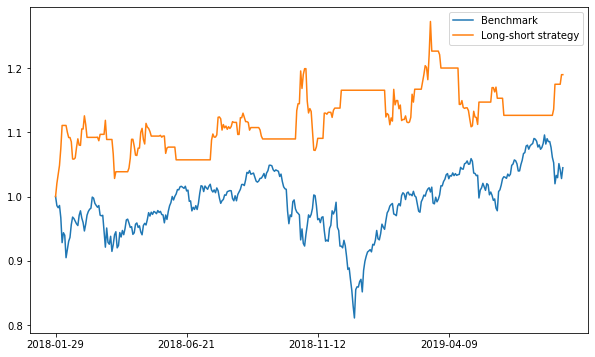

--------------------------------------------------
Long portfolio performance：
Average Annualized Return is:  0.0
Information Ratio is:  -0.802023125202408
Maximum Drawdown is:  0.0
--------------------------------------------------
Long-short portfolio performance：
Average Annualized Return is:  0.12637794560674087
Information Ratio is:  0.8612722448844021
Maximum Drawdown is:  -0.16392573440583713
5-Day Prediction:
              precision    recall  f1-score   support

          -1       0.63      0.95      0.76       149
           1       0.59      0.11      0.18        92

    accuracy                           0.63       241
   macro avg       0.61      0.53      0.47       241
weighted avg       0.62      0.63      0.54       241

[[142   7]
 [ 82  10]]
0.6307053941908713


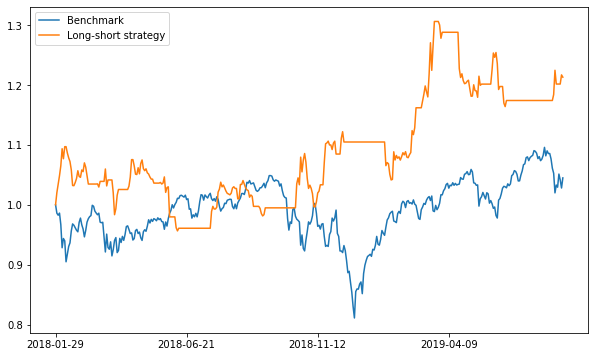

--------------------------------------------------
Long portfolio performance：
Average Annualized Return is:  0.05793746759755799
Information Ratio is:  0.8928746956348985
Maximum Drawdown is:  -0.08843381184383847
--------------------------------------------------
Long-short portfolio performance：
Average Annualized Return is:  0.14089356265440395
Information Ratio is:  0.8894914929718475
Maximum Drawdown is:  -0.14210325491963305
21-Day Prediction:
              precision    recall  f1-score   support

          -1       0.55      0.71      0.62       128
           1       0.51      0.34      0.40       113

    accuracy                           0.54       241
   macro avg       0.53      0.52      0.51       241
weighted avg       0.53      0.54      0.52       241

[[91 37]
 [75 38]]
0.5352697095435685


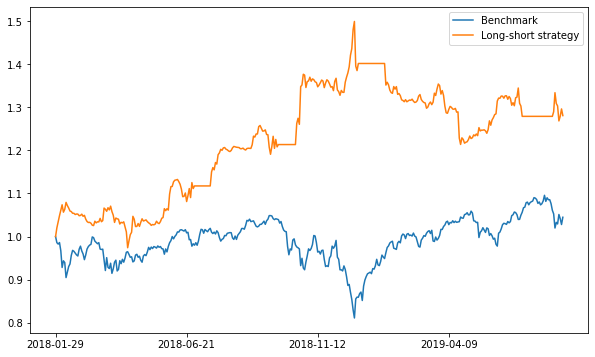

--------------------------------------------------
Long portfolio performance：
Average Annualized Return is:  0.18728011049801493
Information Ratio is:  1.2318204010496718
Maximum Drawdown is:  -0.1939255240121287
--------------------------------------------------
Long-short portfolio performance：
Average Annualized Return is:  0.17467743039235617
Information Ratio is:  1.1456454771822875
Maximum Drawdown is:  -0.2854371584955797
42-Day Prediction:
              precision    recall  f1-score   support

          -1       0.56      0.58      0.57       124
           1       0.54      0.51      0.52       117

    accuracy                           0.55       241
   macro avg       0.55      0.55      0.55       241
weighted avg       0.55      0.55      0.55       241

[[72 52]
 [57 60]]
0.5477178423236515


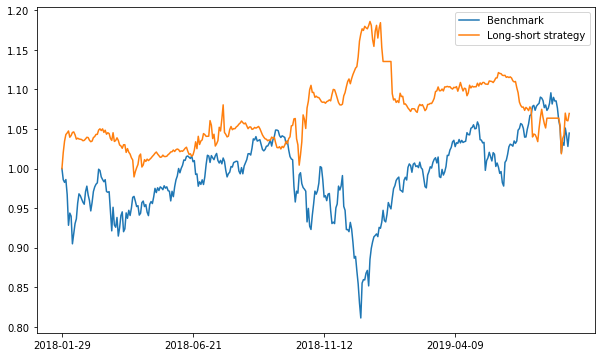

--------------------------------------------------
Long portfolio performance：
Average Annualized Return is:  0.12941089869097278
Information Ratio is:  0.6871849393036471
Maximum Drawdown is:  -0.23992862893243794
--------------------------------------------------
Long-short portfolio performance：
Average Annualized Return is:  0.05014580509406133
Information Ratio is:  0.5712551812666389
Maximum Drawdown is:  -0.16737441833731093


In [60]:
#xgboost
xgbmodel = xgb.XGBClassifier(learning_rate=0.02,
    n_estimators=50,
    objective="binary:logistic",
    nthread=4,**{'min_child_weight': 1,
                 'gamma': 5,
                 'subsample': 1.0,
                 'colsample_bytree': 1.0,
                 'max_depth': 6})
modeling_result(X_train2, X_test2, xgbmodel, train_list, test_list, [3, 5, 21, 42])

### Accuracy

In [94]:
xgbmodel.score(X_train,y_train)  # in sample

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12']
training data did not have the following fields: f9, f6, f12, f5, f8, f10, f11, f7

In [95]:
xgbmodel.score(X_test,y_test)  # out of sample

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12']
training data did not have the following fields: f9, f6, f12, f5, f8, f10, f11, f7

### Feature Importance

In [96]:
feature_importance = pd.DataFrame() 
feature_importance["feature"] = features
feature_importance["Importance"] = xgbmodel.feature_importances_*100
feature_importance

ValueError: Length of values does not match length of index

## 6.3.2 Using features that have low multi-colinearity

In [100]:
clf = XGBClassifier(n_estimators = 100, n_jobs=4)#,objective='multi:softprob')
fit = clf.fit(X_train2,y_train)
preds = clf.predict(X_test2)
predproba = clf.predict_proba(X_test2)
auc_score = roc_auc_score(y_test, preds, multi_class='ovr')

In [101]:
auc_score

0.519322278298486

In [ ]:
params = {
    "min_child_weight": [1, 5, 10],
    "gamma": [0.5, 1, 1.5, 2, 5],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "max_depth": [5, 6, 8],
}

xgb_m = xgb.XGBClassifier(
    learning_rate=0.02,
    n_estimators=50,
    objective='binary:logistic',
    nthread=4,
    # tree_method="gpu_hist"  # this enables GPU.
    # See https://github.com/dmlc/xgboost/issues/2819
)

digit_search = TuneSearchCV(
    xgb_m,
    param_distributions=params,
    n_trials=3,
    early_stopping=False,
    # use_gpu=True # Commented out for testing on travis,
    # but this is how you would use gpu
)

digit_search.fit(X_train2, y_train)
print(digit_search.best_params_)
#print(digit_search.cv_results_)

In [91]:
xgbmodel = xgb.XGBClassifier(learning_rate=0.02,
    n_estimators=50,
    objective="binary:logistic",
    nthread=4,**{'min_child_weight': 10,
                 'gamma': 0.5,
                 'subsample': 0.8,
                 'colsample_bytree': 0.8,
                 'max_depth': 5})
xgbmodel.fit(X_train2, y_train)
# joblib.dump(xgbmodel, 'xgboost')

y_pred = xgbmodel.predict(X_test2)
prob = xgbmodel.predict_proba(X_test2)

In [ ]:
plt.hist(y_pred)

### Accuracy

In [681]:
xgbmodel.score(X_train2,y_train)  # in sample

0.6561032863849765

In [682]:
xgbmodel.score(X_test2,y_test)  # out of sample

0.6224066390041494

### Feature Importance

In [683]:
xgbmodel.feature_importances_

array([0.19118015, 0.18503597, 0.22106995, 0.19116317, 0.2115508 ],
      dtype=float32)

In [684]:
feature_importance = pd.DataFrame() 
feature_importance["feature"] = selected_features
feature_importance["Importance"] = xgbmodel.feature_importances_*100

In [685]:
feature_importance

,feature,Importance
0,Polarity LM,19.118015
1,Polarity LM extended,18.503597
2,Polarity of sentences,22.106995
3,Avg length of sentences in MD,19.116316
4,Percentage neutral sentences,21.155081


## 6.3.3 Using only FinBERT features

In [686]:
params = {
    "min_child_weight": [1, 5, 10],
    "gamma": [0.5, 1, 1.5, 2, 5],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "max_depth": [5, 6, 8],
}

xgb_m = xgb.XGBClassifier(
    learning_rate=0.02,
    n_estimators=50,
    objective='binary:logistic',
    nthread=4,
    # tree_method="gpu_hist"  # this enables GPU.
    # See https://github.com/dmlc/xgboost/issues/2819
)

digit_search = TuneSearchCV(
    xgb_m,
    param_distributions=params,
    n_trials=3,
    early_stopping=False,
    # use_gpu=True # Commented out for testing on travis,
    # but this is how you would use gpu
)

digit_search.fit(X_train3, y_train)
print(digit_search.best_params_)
#print(digit_search.cv_results_)

{'min_child_weight': 10, 'gamma': 1.5, 'subsample': 0.6, 'colsample_bytree': 1.0, 'max_depth': 5}


In [687]:
xgbmodel = xgb.XGBClassifier(learning_rate=0.02,
    n_estimators=50,
    objective="binary:logistic",
    nthread=4,**{'min_child_weight': 10,
                 'gamma': 2,
                 'subsample': 0.8,
                 'colsample_bytree': 0.6,
                 'max_depth': 5})
xgbmodel.fit(X_train3, y_train)
# joblib.dump(xgbmodel, 'xgboost')

y_pred = xgbmodel.predict(X_test3)
prob = xgbmodel.predict_proba(X_test3)

(array([  0.,   0.,   0.,   0.,   0., 241.,   0.,   0.,   0.,   0.]),
 array([-1.5, -1.4, -1.3, -1.2, -1.1, -1. , -0.9, -0.8, -0.7, -0.6, -0.5]),
 <a list of 10 Patch objects>)

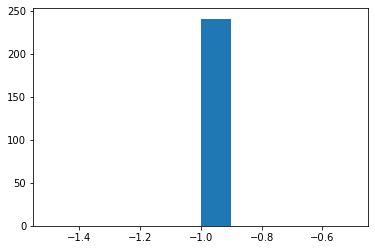

In [688]:
plt.hist(y_pred)

### Accuracy 

In [689]:
xgbmodel.score(X_train3,y_train)  # in sample


0.6302816901408451

In [690]:
xgbmodel.score(X_test3,y_test)  # out of sample

0.6058091286307054

### Feature Importance

In [695]:
feature_importance3 = pd.DataFrame() 
feature_importance3["feature"] = selected_features3
feature_importance3["Importance"] = xgbmodel.feature_importances_*100

In [696]:
feature_importance3

,feature,Importance
0,Polarity of sentences,39.544586
1,Avg length of sentences in MD,27.437443
2,Percentage neutral sentences,33.017975


## 6.4 Decision Trees

In [697]:
from sklearn import tree

In [698]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [699]:
preds = clf.predict(X_test)

In [700]:
auc = accuracy_score(y_test, preds)
auc

0.4979253112033195

In [701]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train2, y_train)

In [702]:
preds = clf.predict(X_test2)

In [703]:
auc = accuracy_score(y_test, preds)
auc

0.5643153526970954

In [704]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train3, y_train)

In [705]:
preds = clf.predict(X_test3)

In [706]:
auc = accuracy_score(y_test, preds)
auc

0.5477178423236515